In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from config import get_default_cfg
from sae import VanillaSAE, TopKSAE, BatchTopKSAE, JumpReLUSAE
import transformer_lens
from transformer_lens import HookedTransformer, HookedEncoder
from transformers import GPT2Tokenizer, GPT2Model, BertModel, BertTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import tqdm

D:\Escritorio\PythonProyects\SparseAutoencodersTFM\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
bert_dict_path = "bert-base-uncased_layer11_resid-pre_batchtopk_with_feature_embeddings.json"
gpt2_dict_path = "gpt2-small_layer11_resid-pre_batchtopk_with_feature_embeddings.json"

num_features = int(6144)
feature_dim = int(768)

def load_feature_embeddings(path):
    file_size = os.path.getsize(path) / (1024 * 1024)
    print(f"Loading embeddings from {path} ({file_size:.2f} MB)")

    num_feats = 0
    embed_dim = None

    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        num_features = len(data)

        # Obtener dimensión del primer embedding disponible
        for feature_id, feature_data in data.items():
            if 'feature_embedding' in feature_data:
                embed_dim = len(feature_data['feature_embedding'])
                break

    if embed_dim is None:
        raise ValueError("No 'feature_embedding' in file.")

    print(f"Creating matrix for {num_features} features with dimension {embed_dim}")

    # Segunda pasada: llenar la matriz
    features_matrix = np.zeros((num_features, embed_dim), dtype=np.float32)

    for feature_id, feature_data in tqdm.tqdm(data.items(), total=num_features):
        if 'feature_embedding' in feature_data:
            idx = int(feature_id)
            features_matrix[idx] = feature_data['feature_embedding']

    return features_matrix

In [8]:
bert_embeddings = torch.tensor(load_feature_embeddings(bert_dict_path), dtype=torch.float32)
gpt2_embeddings = torch.tensor(load_feature_embeddings(gpt2_dict_path), dtype=torch.float32)

print(f"Matriz BERT: {bert_embeddings.shape}")
print(f"Matriz GPT-2: {gpt2_embeddings.shape}")

Loading embeddings from bert-base-uncased_layer11_resid-pre_batchtopk_with_feature_embeddings.json (2666.70 MB)
Creating matrix for 6144 features with dimension 768


100%|██████████| 6144/6144 [00:00<00:00, 47070.46it/s]


Loading embeddings from gpt2-small_layer11_resid-pre_batchtopk_with_feature_embeddings.json (2810.24 MB)
Creating matrix for 6144 features with dimension 768


100%|██████████| 6144/6144 [00:00<00:00, 39715.87it/s]


Matriz BERT: torch.Size([6144, 768])
Matriz GPT-2: torch.Size([6144, 768])


---

In [3]:
bert = torch.load('bert_embeddings.pt')
gpt2 = torch.load('gpt2_embeddings.pt')
bert.shape, gpt2.shape

(torch.Size([6144, 768]), torch.Size([6144, 768]))

Calculating similarity matrix for BERT features...
Processed 512/6144 features
Processed 1024/6144 features
Processed 1536/6144 features
Processed 2048/6144 features
Processed 2560/6144 features
Processed 3072/6144 features
Processed 3584/6144 features
Processed 4096/6144 features
Processed 4608/6144 features
Processed 5120/6144 features
Processed 5632/6144 features
Processed 6144/6144 features
Calculating similarity matrix for GPT2 features...
Processed 512/6144 features
Processed 1024/6144 features
Processed 1536/6144 features
Processed 2048/6144 features
Processed 2560/6144 features
Processed 3072/6144 features
Processed 3584/6144 features
Processed 4096/6144 features
Processed 4608/6144 features
Processed 5120/6144 features
Processed 5632/6144 features
Processed 6144/6144 features


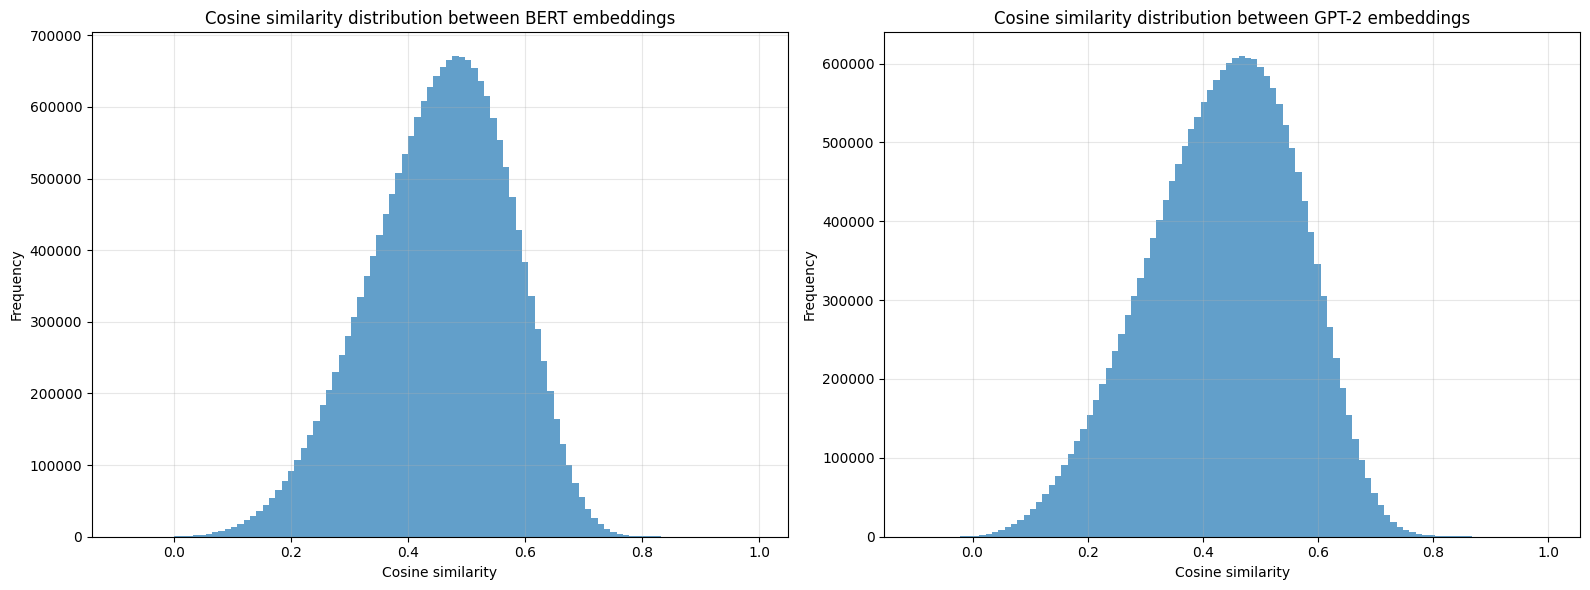

Estadísticas BERT - Mean: 0.4524, STD: 0.1186
Estadísticas GPT-2 - Mean: 0.4339, STD: 0.1295


In [7]:
def calcular_matriz_similitud(embeddings, batch_size=512):
    n_features = embeddings.shape[0]
    device = embeddings.device

    # Normalizar los vectores para el cálculo de similitud coseno
    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

    # Crear matriz de similitud vacía
    similarity_matrix = torch.zeros((n_features, n_features), device=device)

    # Calcular similitudes por lotes
    for i in range(0, n_features, batch_size):
        end_i = min(i + batch_size, n_features)
        batch_i = normalized_embeddings[i:end_i]

        for j in range(0, n_features, batch_size):
            end_j = min(j + batch_size, n_features)
            batch_j = normalized_embeddings[j:end_j]

            # Calcular similitud coseno para el lote actual
            sim_batch = torch.mm(batch_i, batch_j.transpose(0, 1))

            # Guardar resultados en la matriz de similitud
            similarity_matrix[i:end_i, j:end_j] = sim_batch

        # Mostrar progreso
        print(f"Processed {end_i}/{n_features} features")

    return similarity_matrix

# Calcular matrices de similitud para BERT y GPT-2
print("Calculating similarity matrix for BERT features...")
bert_similarity = calcular_matriz_similitud(bert)

print("Calculating similarity matrix for GPT2 features...")
gpt2_similarity = calcular_matriz_similitud(gpt2)

# Visualizar distribución de similitudes
def visualize_distributions(bert_sim, gpt2_sim):
    # Convertir a CPU y numpy para visualización
    bert_sim_np = bert_sim.cpu().numpy()
    gpt2_sim_np = gpt2_sim.cpu().numpy()

    # Obtener valores de la parte triangular superior (sin la diagonal)
    bert_values = bert_sim_np[np.triu_indices_from(bert_sim_np, k=1)]
    gpt2_values = gpt2_sim_np[np.triu_indices_from(gpt2_sim_np, k=1)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Histograma para BERT
    ax1.hist(bert_values, bins=100, alpha=0.7)
    ax1.set_title('Cosine similarity distribution between BERT embeddings')
    ax1.set_xlabel('Cosine similarity')
    ax1.set_ylabel('Frequency')
    ax1.grid(alpha=0.3)

    # Histograma para GPT-2
    ax2.hist(gpt2_values, bins=100, alpha=0.7)
    ax2.set_title('Cosine similarity distribution between GPT-2 embeddings')
    ax2.set_xlabel('Cosine similarity')
    ax2.set_ylabel('Frequency')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Imprimir estadísticas
    print(f"Estadísticas BERT - Mean: {np.mean(bert_values):.4f}, STD: {np.std(bert_values):.4f}")
    print(f"Estadísticas GPT-2 - Mean: {np.mean(gpt2_values):.4f}, STD: {np.std(gpt2_values):.4f}")

# Visualizar distribuciones
visualize_distributions(bert_similarity, gpt2_similarity)

# Guardar las matrices de similitud
# torch.save(bert_similarity, 'bert_similarity_matrix.pt')
# torch.save(gpt2_similarity, 'gpt2_similarity_matrix.pt')

Analizando características de BERT...
Analizando características de GPT-2...

BERT: 6144 características (100.00%) tienen al menos una similitud > 0.4
GPT-2: 6144 características (100.00%) tienen al menos una similitud > 0.4


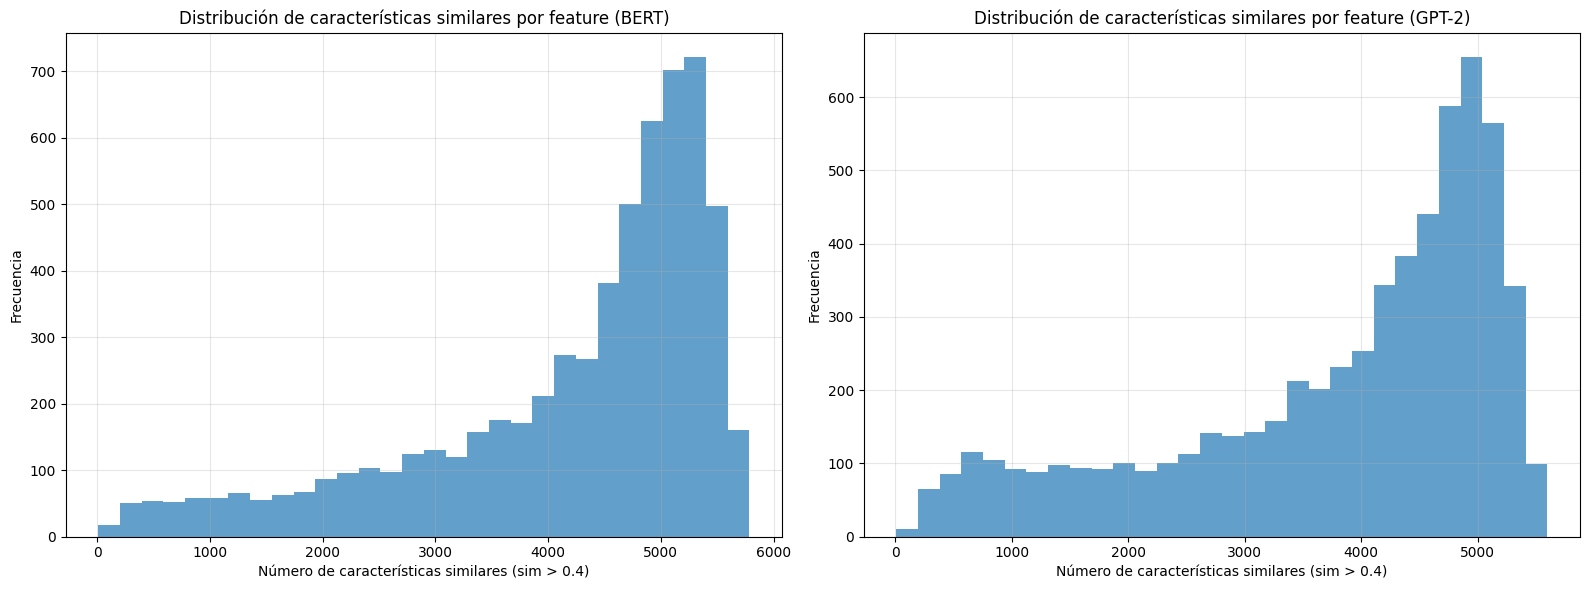


Características BERT con más similares:
1. Feature 3090: 5786 similares, max_sim=0.7443
2. Feature 570: 5785 similares, max_sim=0.7774
3. Feature 491: 5768 similares, max_sim=0.7387
4. Feature 6098: 5756 similares, max_sim=0.7935
5. Feature 3893: 5754 similares, max_sim=0.7195
6. Feature 1324: 5746 similares, max_sim=0.7448
7. Feature 4909: 5745 similares, max_sim=0.7600
8. Feature 3564: 5742 similares, max_sim=0.7423
9. Feature 3853: 5742 similares, max_sim=0.7610
10. Feature 712: 5738 similares, max_sim=0.7082

Características GPT-2 con más similares:
1. Feature 1379: 5598 similares, max_sim=0.7883
2. Feature 3641: 5585 similares, max_sim=0.7766
3. Feature 4934: 5569 similares, max_sim=0.7494
4. Feature 199: 5545 similares, max_sim=0.7383
5. Feature 5520: 5537 similares, max_sim=0.8990
6. Feature 5205: 5535 similares, max_sim=0.7715
7. Feature 4873: 5531 similares, max_sim=0.7510
8. Feature 2706: 5526 similares, max_sim=0.7109
9. Feature 259: 5521 similares, max_sim=0.7538
10. Featu

In [15]:
def analizar_caracteristicas_por_similitud(matriz_similitud, umbral=0.4):
    """
    Analiza cada característica para identificar cuántas otras tienen similitud mayor al umbral.

    Args:
        matriz_similitud: Matriz de similitudes coseno
        umbral: Umbral de similitud para considerar

    Returns:
        dict: Diccionario con estadísticas por característica
    """
    num_features = matriz_similitud.shape[0]
    resultados = {}

    # Para cada característica, calcular cuántas conexiones tiene
    for i in range(num_features):
        # Excluir la similitud consigo misma (siempre es 1.0)
        similares = (matriz_similitud[i, :] > umbral).sum().item() - 1

        resultados[i] = {
            'num_similares': similares,
            'max_similitud': torch.max(matriz_similitud[i, torch.arange(num_features) != i]).item(),
            'media_similitud': torch.mean(matriz_similitud[i, torch.arange(num_features) != i]).item()
        }

    return resultados

# Analizar las características de BERT
print("Analizando características de BERT...")
bert_stats = analizar_caracteristicas_por_similitud(bert_similarity, umbral=0.4)

# Analizar las características de GPT-2
print("Analizando características de GPT-2...")
gpt2_stats = analizar_caracteristicas_por_similitud(gpt2_similarity, umbral=0.4)

# Contar cuántas características tienen al menos una similitud > 0.4
bert_con_similares = sum(1 for stats in bert_stats.values() if stats['num_similares'] > 0)
gpt2_con_similares = sum(1 for stats in gpt2_stats.values() if stats['num_similares'] > 0)

print(f"\nBERT: {bert_con_similares} características ({bert_con_similares/len(bert_stats)*100:.2f}%) tienen al menos una similitud > 0.4")
print(f"GPT-2: {gpt2_con_similares} características ({gpt2_con_similares/len(gpt2_stats)*100:.2f}%) tienen al menos una similitud > 0.4")

# Crear histograma de número de similitudes por característica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histograma para BERT
bert_counts = [stats['num_similares'] for stats in bert_stats.values()]
ax1.hist(bert_counts, bins=30, alpha=0.7)
ax1.set_title('Distribución de características similares por feature (BERT)')
ax1.set_xlabel('Número de características similares (sim > 0.4)')
ax1.set_ylabel('Frecuencia')
ax1.grid(alpha=0.3)

# Histograma para GPT-2
gpt2_counts = [stats['num_similares'] for stats in gpt2_stats.values()]
ax2.hist(gpt2_counts, bins=30, alpha=0.7)
ax2.set_title('Distribución de características similares por feature (GPT-2)')
ax2.set_xlabel('Número de características similares (sim > 0.4)')
ax2.set_ylabel('Frecuencia')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar las características con más similares
def caracteristicas_mas_conectadas(stats_dict, top_n=10):
    """Devuelve las características con más conexiones"""
    sorted_features = sorted(stats_dict.items(), key=lambda x: x[1]['num_similares'], reverse=True)
    return sorted_features[:top_n]

print("\nCaracterísticas BERT con más similares:")
for idx, (feat_id, stats) in enumerate(caracteristicas_mas_conectadas(bert_stats)):
    print(f"{idx+1}. Feature {feat_id}: {stats['num_similares']} similares, max_sim={stats['max_similitud']:.4f}")

print("\nCaracterísticas GPT-2 con más similares:")
for idx, (feat_id, stats) in enumerate(caracteristicas_mas_conectadas(gpt2_stats)):
    print(f"{idx+1}. Feature {feat_id}: {stats['num_similares']} similares, max_sim={stats['max_similitud']:.4f}")

Procesando embeddings de BERT...
Aplicando TSNE a 6144 embeddings...


D:\Escritorio\PythonProyects\SparseAutoencodersTFM\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


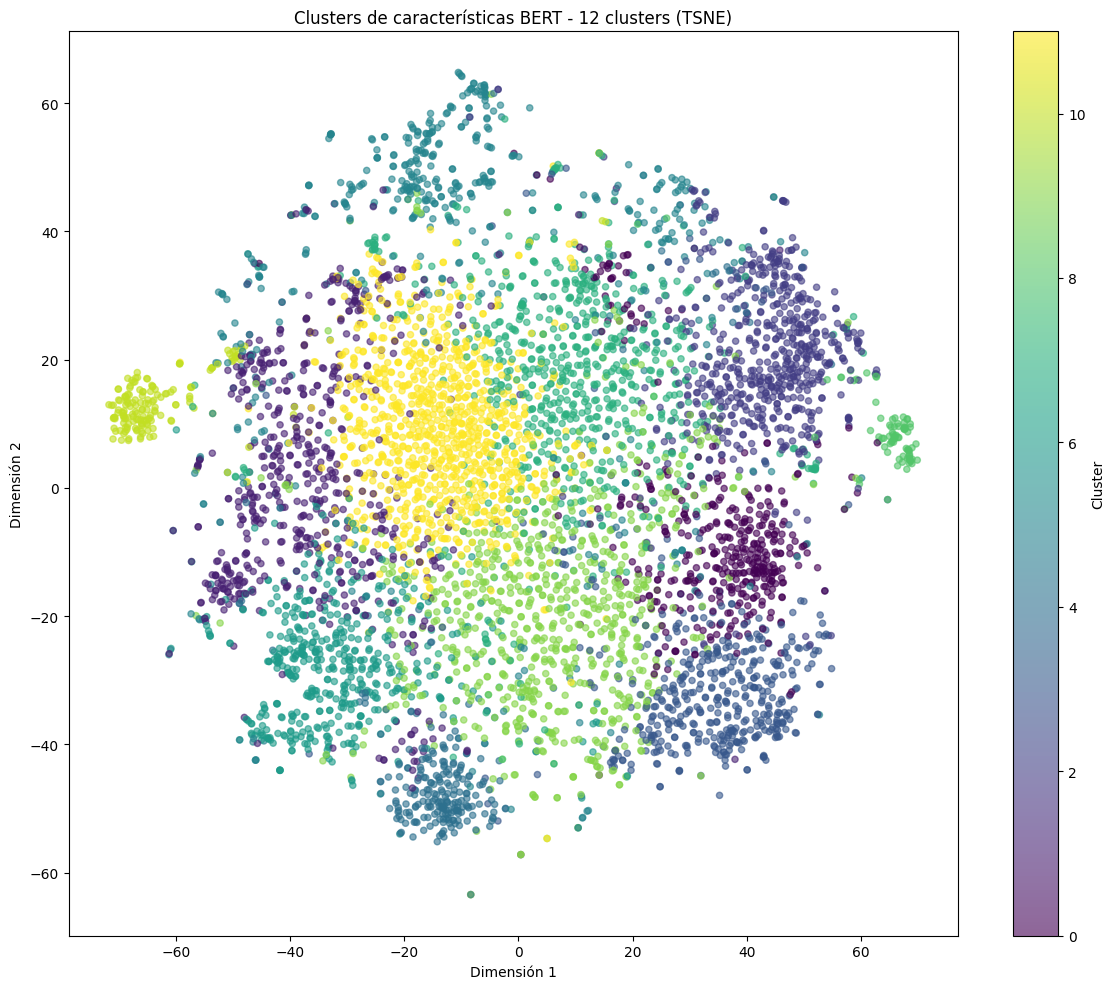

Procesando embeddings de GPT-2...
Aplicando TSNE a 6144 embeddings...


D:\Escritorio\PythonProyects\SparseAutoencodersTFM\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


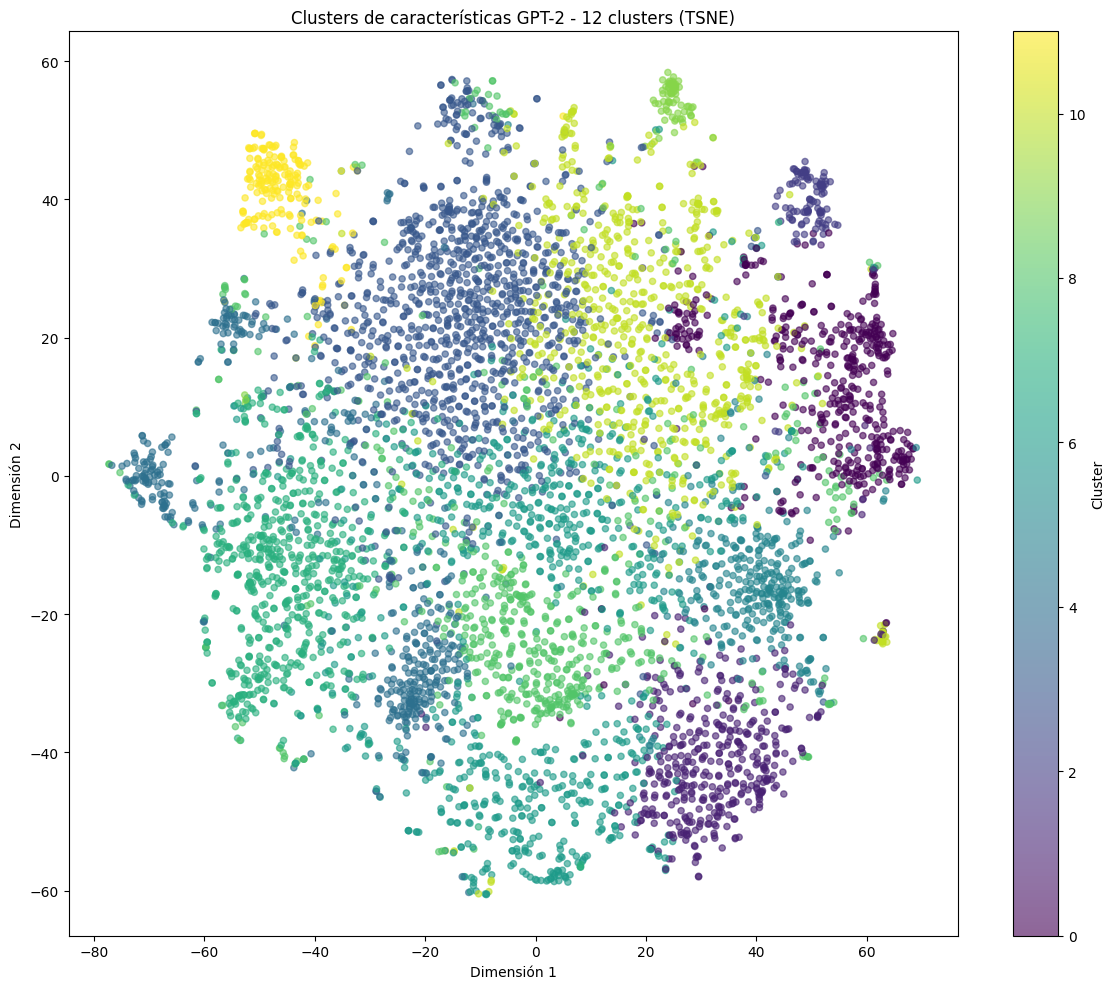

Clustering jerárquico para BERT...
Calculando linkage jerárquico para 1000 muestras...


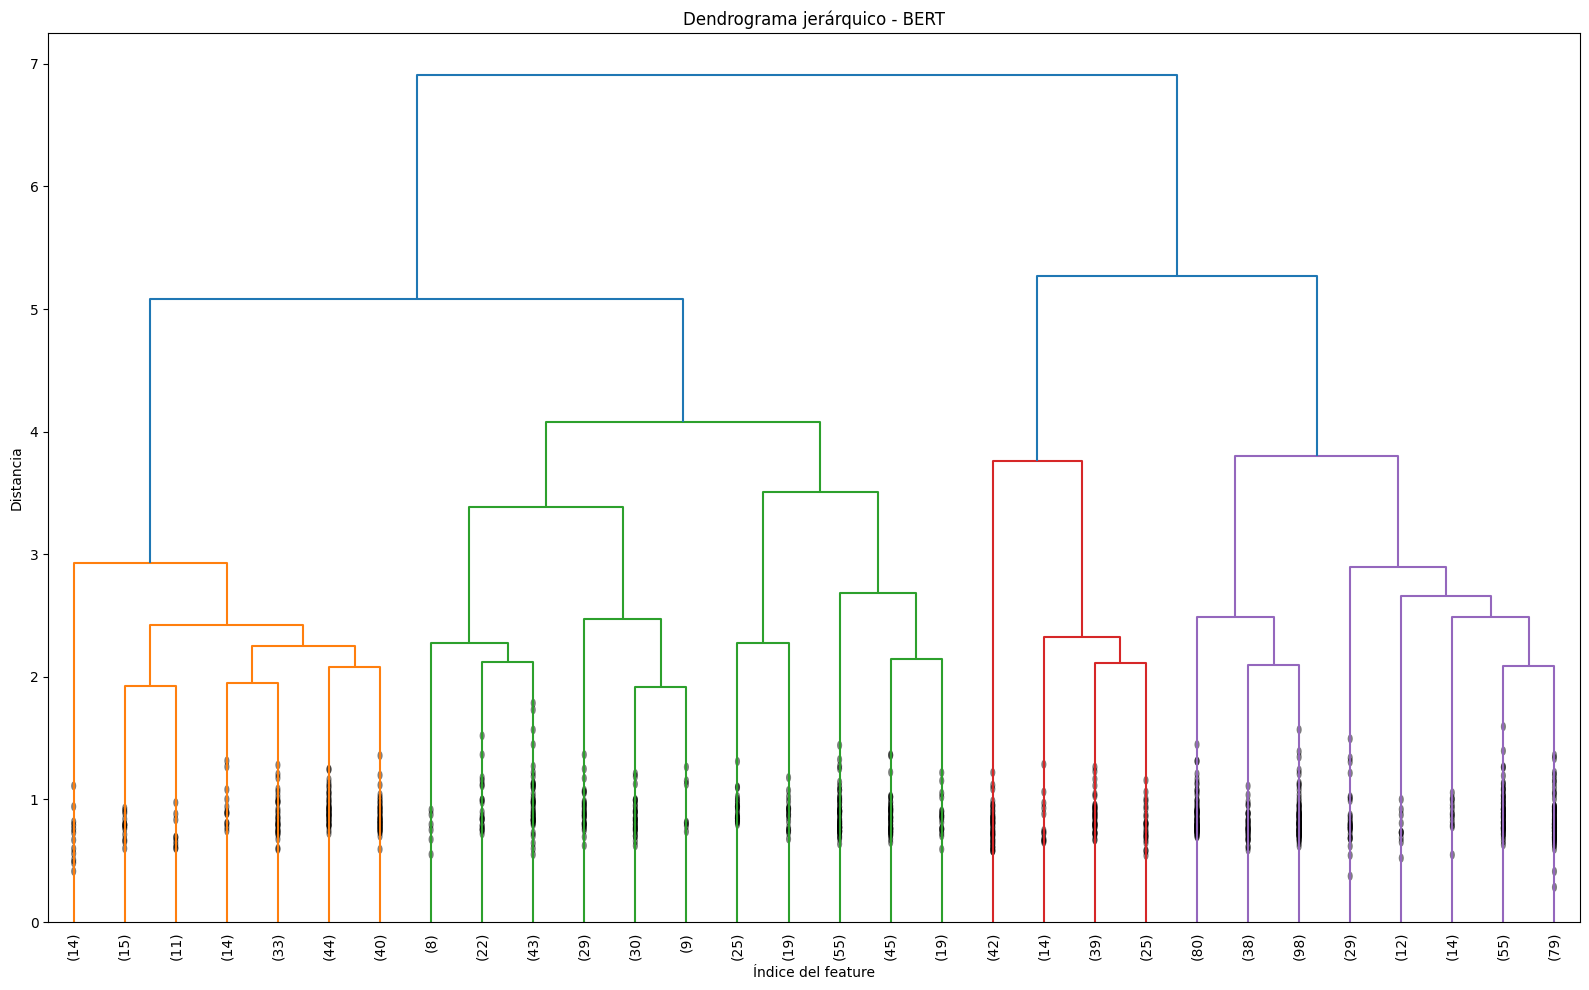

Clustering jerárquico para GPT-2...
Calculando linkage jerárquico para 1000 muestras...


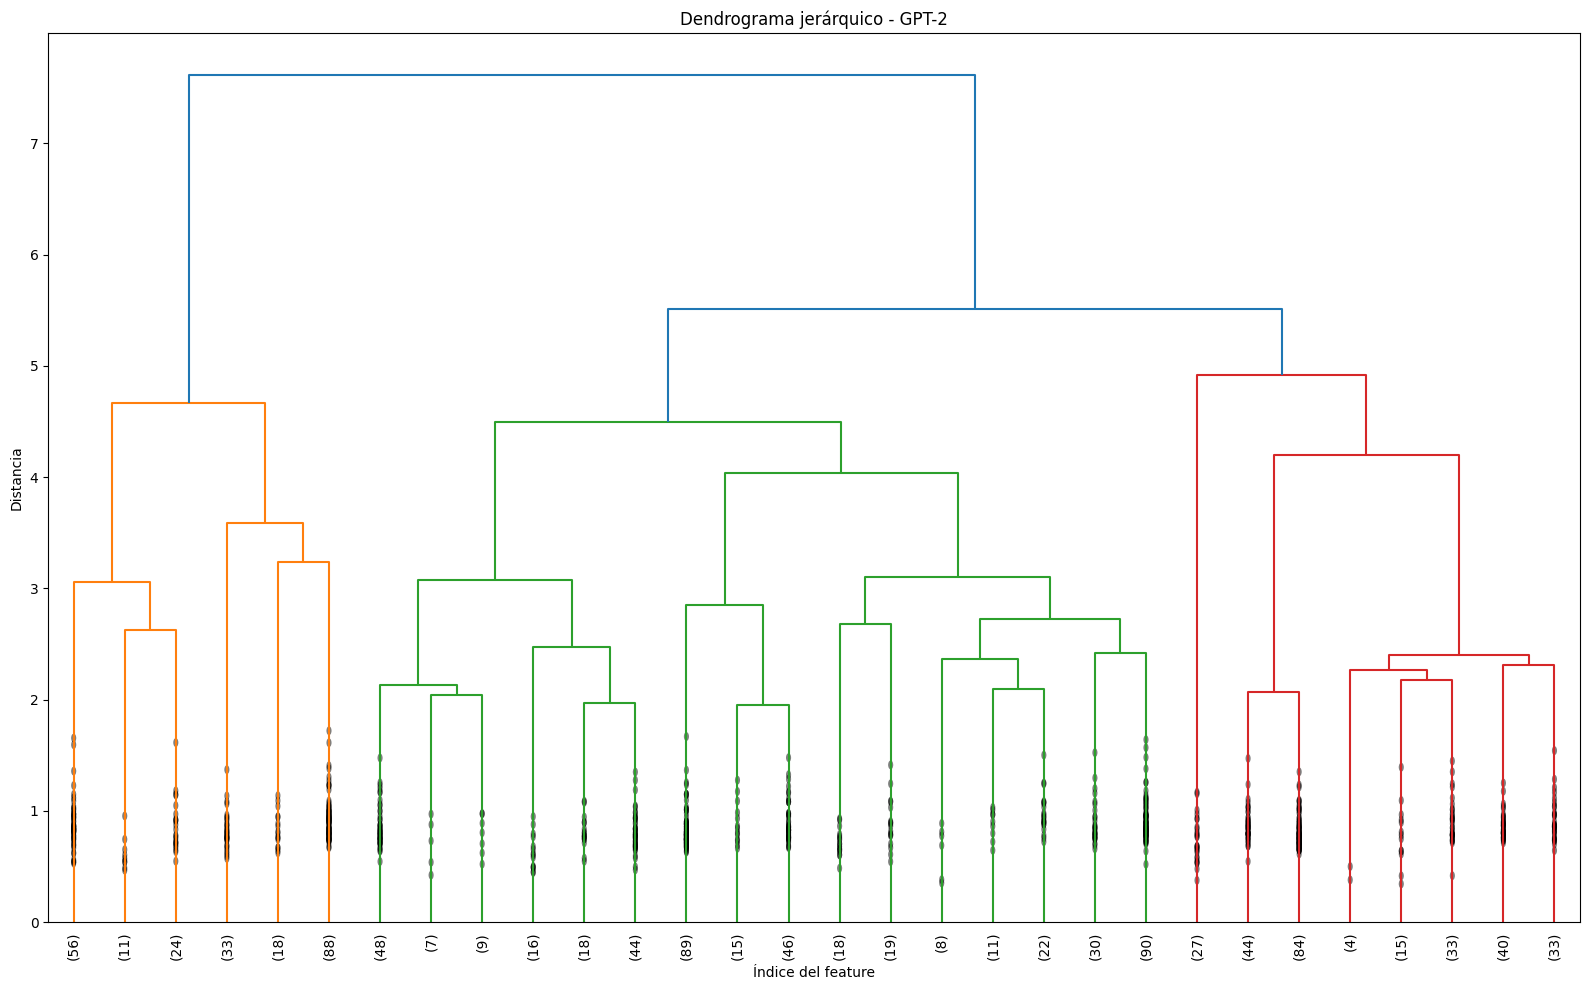

Analizando clusters de BERT...


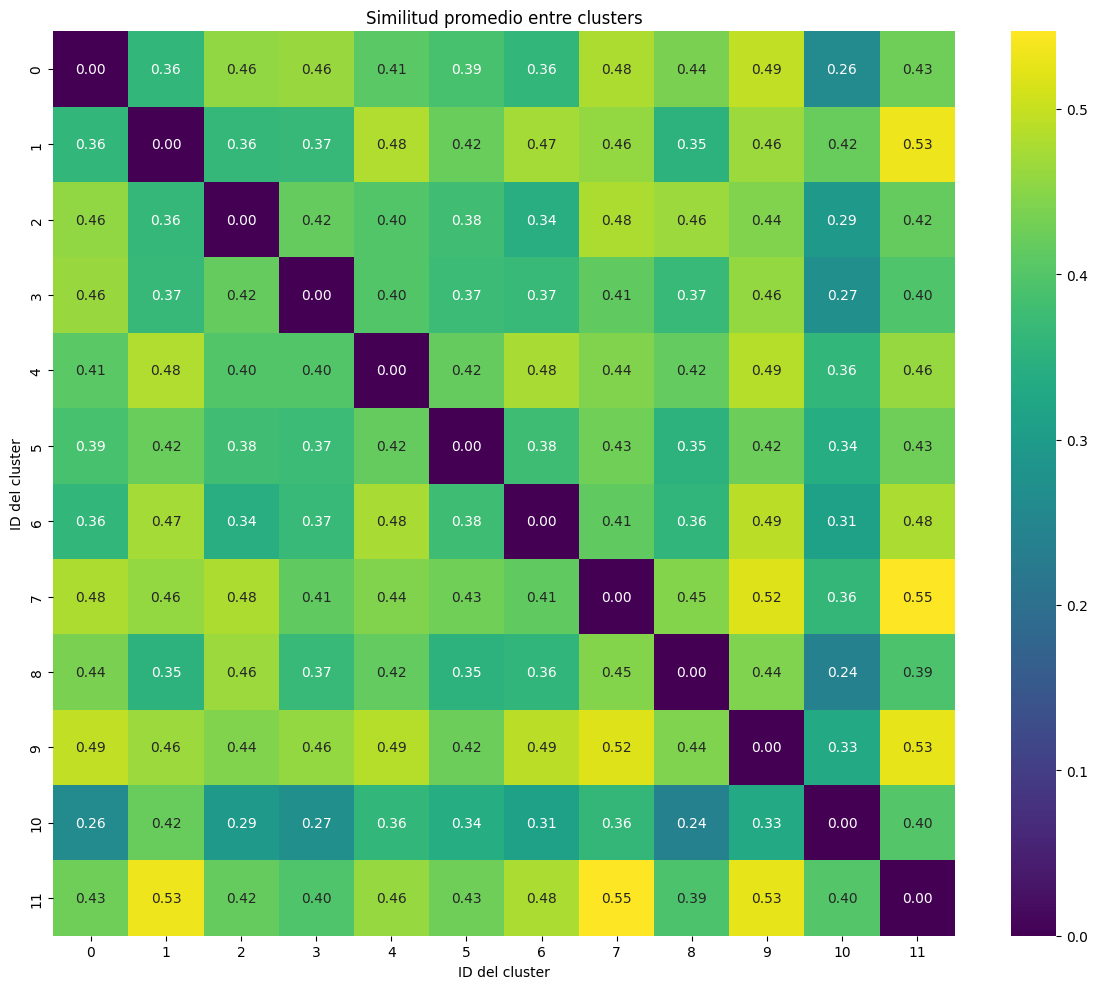

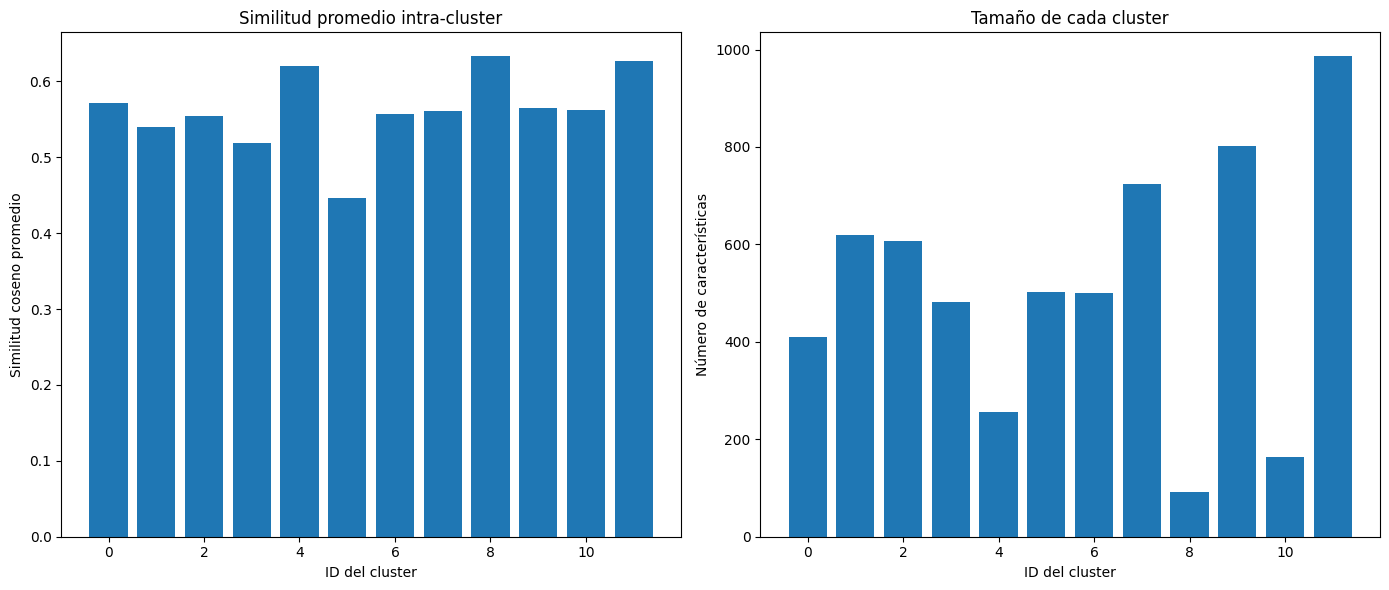

Analizando clusters de GPT-2...


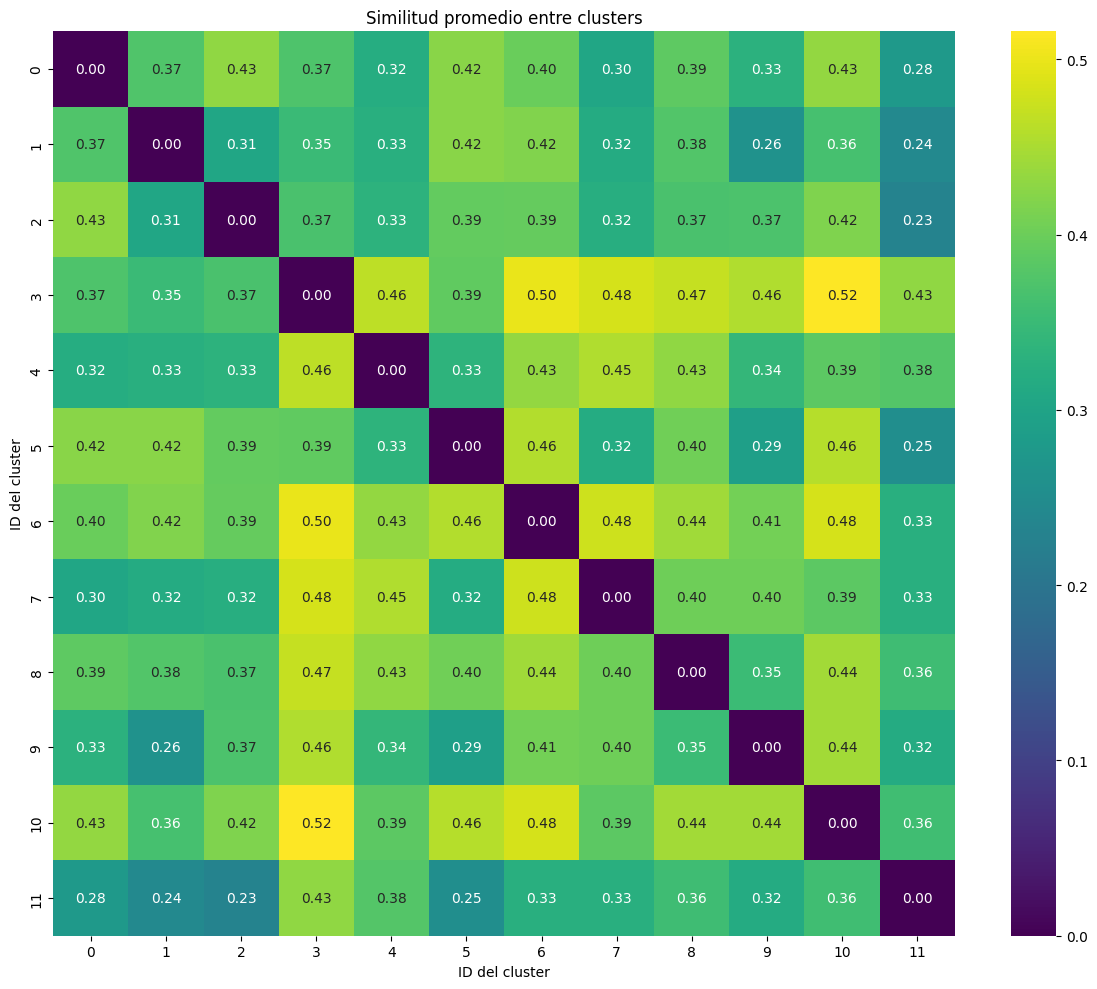

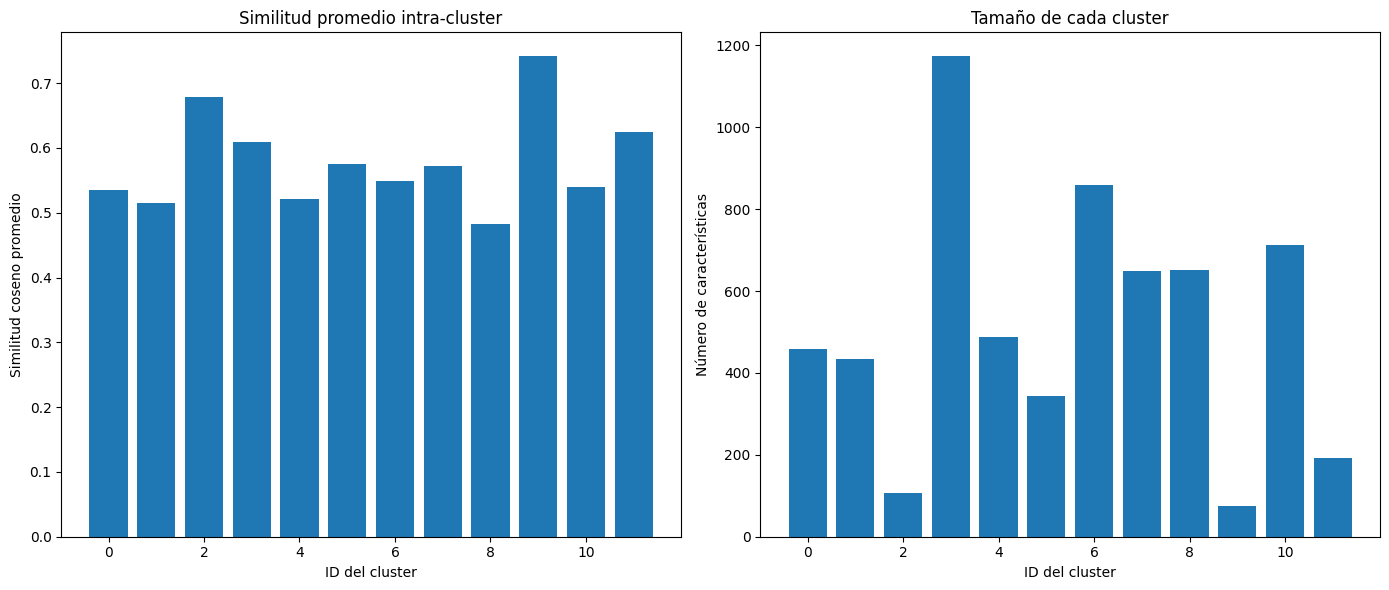

In [16]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

def visualizar_clusters(embeddings, metodo='tsne', n_clusters=10, titulo=''):
    """
    Visualiza clusters de embeddings usando diferentes técnicas

    Args:
        embeddings: Matriz de embeddings (tensor)
        metodo: 'tsne', 'pca' o 'mds'
        n_clusters: Número de clusters para K-Means
        titulo: Título del gráfico
    """
    # Convertir tensor a numpy
    embeddings_np = embeddings.cpu().numpy()

    # Reducción de dimensionalidad
    print(f"Aplicando {metodo.upper()} a {embeddings_np.shape[0]} embeddings...")

    if metodo == 'tsne':
        # t-SNE para visualización (más adecuado para preservar estructura local)
        reduced_data = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42).fit_transform(embeddings_np)
    elif metodo == 'pca':
        # PCA para visualización (más rápido pero preserva menos estructura local)
        reduced_data = PCA(n_components=2, random_state=42).fit_transform(embeddings_np)
    elif metodo == 'mds':
        # MDS para visualización (preserva distancias globales)
        reduced_data = MDS(n_components=2, n_jobs=-1, random_state=42).fit_transform(embeddings_np)

    # Aplicar clustering K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings_np)

    # Visualizar
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters,
                         alpha=0.6, s=20, cmap='viridis')

    plt.colorbar(scatter, label='Cluster')
    plt.title(f'{titulo} - {n_clusters} clusters ({metodo.upper()})')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.tight_layout()
    plt.show()

    return clusters, reduced_data

# Aplicar a BERT y GPT-2 (usando una muestra para t-SNE por eficiencia)
n_clusters = 12  # Ajusta según tus necesidades

print("Procesando embeddings de BERT...")
bert_clusters, bert_reduced = visualizar_clusters(bert, metodo='tsne',
                                                n_clusters=n_clusters,
                                                titulo='Clusters de características BERT')

print("Procesando embeddings de GPT-2...")
gpt2_clusters, gpt2_reduced = visualizar_clusters(gpt2, metodo='tsne',
                                                n_clusters=n_clusters,
                                                titulo='Clusters de características GPT-2')

# Análisis de clustering jerárquico (para un subconjunto representativo)
def clustering_jerarquico(embeddings, max_muestra=1000, titulo=''):
    """Realiza clustering jerárquico y muestra el dendrograma"""

    # Si los embeddings son demasiados, usar una muestra representativa
    n_samples = embeddings.shape[0]
    if n_samples > max_muestra:
        indices = np.random.choice(n_samples, max_muestra, replace=False)
        muestra = embeddings[indices].cpu().numpy()
    else:
        muestra = embeddings.cpu().numpy()
        indices = np.arange(n_samples)

    print(f"Calculando linkage jerárquico para {muestra.shape[0]} muestras...")

    # Normalizar los vectores (opcional, dependiendo de tus datos)
    muestra_norm = muestra / np.linalg.norm(muestra, axis=1, keepdims=True)

    # Calcular el linkage
    Z = linkage(muestra_norm, method='ward')

    # Visualizar el dendrograma
    plt.figure(figsize=(16, 10))
    plt.title(f'Dendrograma jerárquico - {titulo}')
    plt.xlabel('Índice del feature')
    plt.ylabel('Distancia')

    # Truncar el dendrograma si hay demasiados nodos
    dendrogram(Z, truncate_mode='lastp', p=30,
               leaf_rotation=90., leaf_font_size=10.,
               show_contracted=True)

    plt.tight_layout()
    plt.show()

    return Z, indices

# Aplicar clustering jerárquico
print("Clustering jerárquico para BERT...")
Z_bert, indices_bert = clustering_jerarquico(bert, max_muestra=1000, titulo='BERT')

print("Clustering jerárquico para GPT-2...")
Z_gpt2, indices_gpt2 = clustering_jerarquico(gpt2, max_muestra=1000, titulo='GPT-2')

# Visualización de relación entre clusters y similitud
def analizar_clusters(embeddings, clusters, similaridad_matrix):
    """Analiza la relación entre clusters y similitud intra/inter cluster"""

    n_clusters = np.max(clusters) + 1
    intra_sim = np.zeros(n_clusters)
    inter_sim = np.zeros((n_clusters, n_clusters))
    cluster_sizes = np.zeros(n_clusters)

    # Para cada cluster
    for i in range(n_clusters):
        # Obtener índices de características en este cluster
        indices = np.where(clusters == i)[0]
        cluster_sizes[i] = len(indices)

        if len(indices) > 1:
            # Calcular similitud promedio intra-cluster
            intra_sim_values = []
            for j in range(len(indices)):
                for k in range(j+1, len(indices)):
                    intra_sim_values.append(similaridad_matrix[indices[j], indices[k]].item())
            intra_sim[i] = np.mean(intra_sim_values)

        # Calcular similitud promedio inter-cluster
        for j in range(i+1, n_clusters):
            indices_j = np.where(clusters == j)[0]
            inter_values = []
            for idx_i in indices:
                for idx_j in indices_j:
                    inter_values.append(similaridad_matrix[idx_i, idx_j].item())
            if inter_values:
                inter_sim[i, j] = np.mean(inter_values)
                inter_sim[j, i] = inter_sim[i, j]

    # Visualizar similitud entre clusters
    plt.figure(figsize=(12, 10))
    sns.heatmap(inter_sim, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Similitud promedio entre clusters')
    plt.xlabel('ID del cluster')
    plt.ylabel('ID del cluster')
    plt.tight_layout()
    plt.show()

    # Visualizar similitud intra-cluster y tamaño
    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(121)
    ax1.bar(range(n_clusters), intra_sim)
    ax1.set_title('Similitud promedio intra-cluster')
    ax1.set_xlabel('ID del cluster')
    ax1.set_ylabel('Similitud coseno promedio')

    ax2 = plt.subplot(122)
    ax2.bar(range(n_clusters), cluster_sizes)
    ax2.set_title('Tamaño de cada cluster')
    ax2.set_xlabel('ID del cluster')
    ax2.set_ylabel('Número de características')

    plt.tight_layout()
    plt.show()

    return intra_sim, inter_sim, cluster_sizes

# Analizar los clusters de BERT y GPT-2
print("Analizando clusters de BERT...")
bert_intra, bert_inter, bert_sizes = analizar_clusters(bert, bert_clusters, bert_similarity)

print("Analizando clusters de GPT-2...")
gpt2_intra, gpt2_inter, gpt2_sizes = analizar_clusters(gpt2, gpt2_clusters, gpt2_similarity)